In [8]:
import pandana as pdna
import geopandas as gpd

In [9]:
import os
os.getcwd()
import glob
glob.glob('/app/assets/streets/actual/*')

['/app/assets/streets/actual/edges',
 '/app/assets/streets/actual/nodes',
 '/app/assets/streets/actual/nodes.parquet',
 '/app/assets/streets/actual/net.h5',
 '/app/assets/streets/actual/edges.parquet']

In [10]:
net_file = '/app/assets/streets/actual/net.h5'
net = pdna.Network.from_hdf5(net_file)

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 35999
Setting CH edge vector of size 79728
Range graph removed 79728 edges of 159456
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [11]:
def load_data():
    area_scope = gpd.read_parquet('/app/assets/area_scope/area_scope.parquet')

    from shapely.geometry import Point

    df = net.nodes_df

    # Creamos la geometría de puntos
    geometry = [Point(xy) for xy in zip(df['x'], df['y'])]

    # Creamos el GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf = gdf.set_crs(area_scope.crs)
    gdf.reset_index(inplace=True)
    return area_scope, gdf

In [12]:
area_scope, gdf = load_data()

In [13]:
area_scope = area_scope.to_crs(4326)
gdf = gdf.to_crs(4326)
sources = gpd.overlay(gdf, area_scope)

<Axes: >

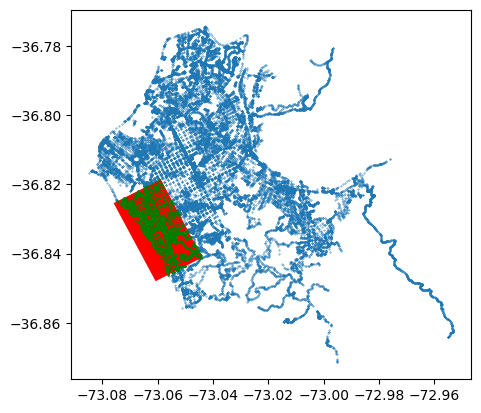

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.plot(ax=ax,markersize=0.1)
area_scope.plot(ax=ax, color='red')
sources.plot(ax=ax, color='green', markersize=0.2)

In [14]:
import requests

In [15]:
endpoint = 'http://clbb-api:8000/urban-indicators/indicatordata/get_table_data/?table_name=am_prox_by_node&indicator_hash=f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a526084ff95ad2b1f066'
response = requests.get(endpoint)

In [16]:
import pandas as pd
df_paths = pd.DataFrame(response.json())

In [17]:
df_paths

,category,path_length,destination,source,hash
0,Aprovisionamiento,841.479,7015838451,9787317265,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
1,Comercio y Servicios,64.970,9816336464,9787317265,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
2,Cuidados,616.449,1919320168,9787317265,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
3,Cultura,822.560,6183914088,9787317265,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
4,Educacion,578.970,9787317273,9787317265,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
...,...,...,...,...,...
22909,Comercio y Servicios,29.880,9816336464,7015759672,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
22910,Cuidados,566.339,1919320168,7015759672,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
22911,Cultura,746.630,6183914088,7015759672,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...
22912,Educacion,558.290,9787317273,7015759672,f9fc2fa10bdb353d4a2e4152a74c9d70bb7baa213d85a5...


In [18]:
df_prox = pd.merge(df_paths.rename(columns={'source': 'osmid'}), sources, on='osmid')
prox_cols = ['osmid','destination', 'category', 'path_length', 'geometry']
df_prox = df_prox[prox_cols]
gdf_prox = gpd.GeoDataFrame(df_prox)

In [19]:
gdf_prox['category'].unique()

array(['Aprovisionamiento', 'Comercio y Servicios', 'Cuidados', 'Cultura',
       'Educacion', 'Entretenimiento'], dtype=object)

<Axes: >

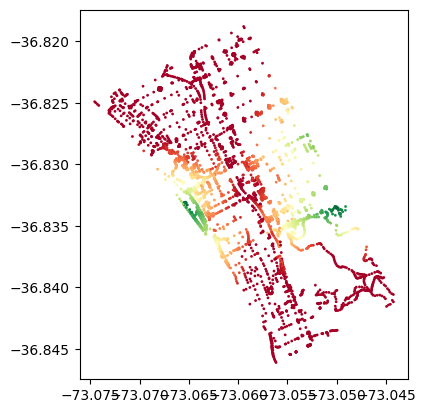

In [34]:
cat = 'Cultura'
tmp = gdf_prox[gdf_prox['category']==cat]
tmp.plot(column='path_length', markersize=1, cmap='RdYlGn_r', vmin=0, vmax=1000)

In [120]:
import seaborn as sns

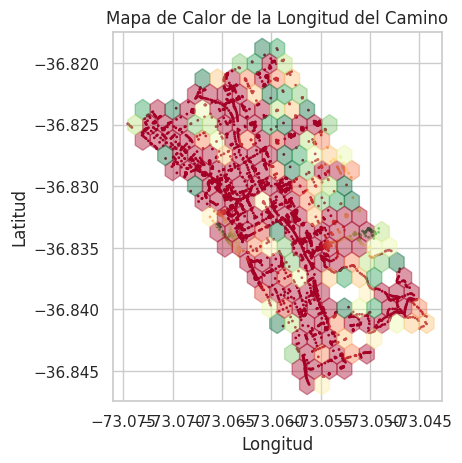

In [123]:
fig, ax = plt.subplots()
# Dibuja el GeoDataFrame con un mapa de calor basado en 'path_length'
sns.set_theme(style="whitegrid")

# Crea el mapa base
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(10, 6))

# Dibuja los puntos como un mapa de calor
# sns.kdeplot(
#     x=tmp.geometry.x,
#     y=tmp.geometry.y,
#     cmap="hot",
#     fill=True,
#     alpha=0.5,
#     ax=ax,
#     cbar=True,
#     cbar_kws={'label': 'Densidad'},
#     weights=tmp['path_length'],  # Usa 'path_length' como pesos para el cálculo de la densidad
# )
tmp.plot(ax=ax, column='path_length', markersize=1, cmap='RdYlGn_r', vmin=0, vmax=500)

# Superpone un mapa de calor normalizado
ax.hexbin(
    tmp.geometry.x,  # Coordenadas x
    tmp.geometry.y,  # Coordenadas y
    # ax=ax,
    vmax=10,
    gridsize=20,  # Tamaño de la cuadrícula
    cmap='RdYlGn_r',  # Colormap para el mapa de calor
    alpha=0.4,  # Transparencia
    mincnt=1  # Conteo mínimo en una celda para ser coloreada
)
# Establece el título y las etiquetas del gráfico
plt.title("Mapa de Calor de la Longitud del Camino")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# Muestra el gráfico
plt.show()